In [76]:
%matplotlib inline
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, IPython.display as ipd
import librosa, librosa.display
import warnings
warnings.simplefilter("ignore")
from midiutil import MIDIFile             #http://midiutil.readthedocs.io/en/1.2.1/
from music21.tempo import MetronomeMark   #http://web.mit.edu/music21/
from music21.note import Note, Rest
from music21.stream import Stream
from music21 import metadata
from music21 import instrument
from music21 import midi 
from music21 import chord 
from music21 import stream 
from music21 import note
from music21 import key
from music21 import meter
import json
import muspy
import sklearn
import math

In [77]:
x, sr = librosa.load("../../data/grandpiano.wav")

APPLY nmf on half a second windows and try to find the maximums, then add the info at the end.

In [78]:
ipd.Audio(x,rate=sr)

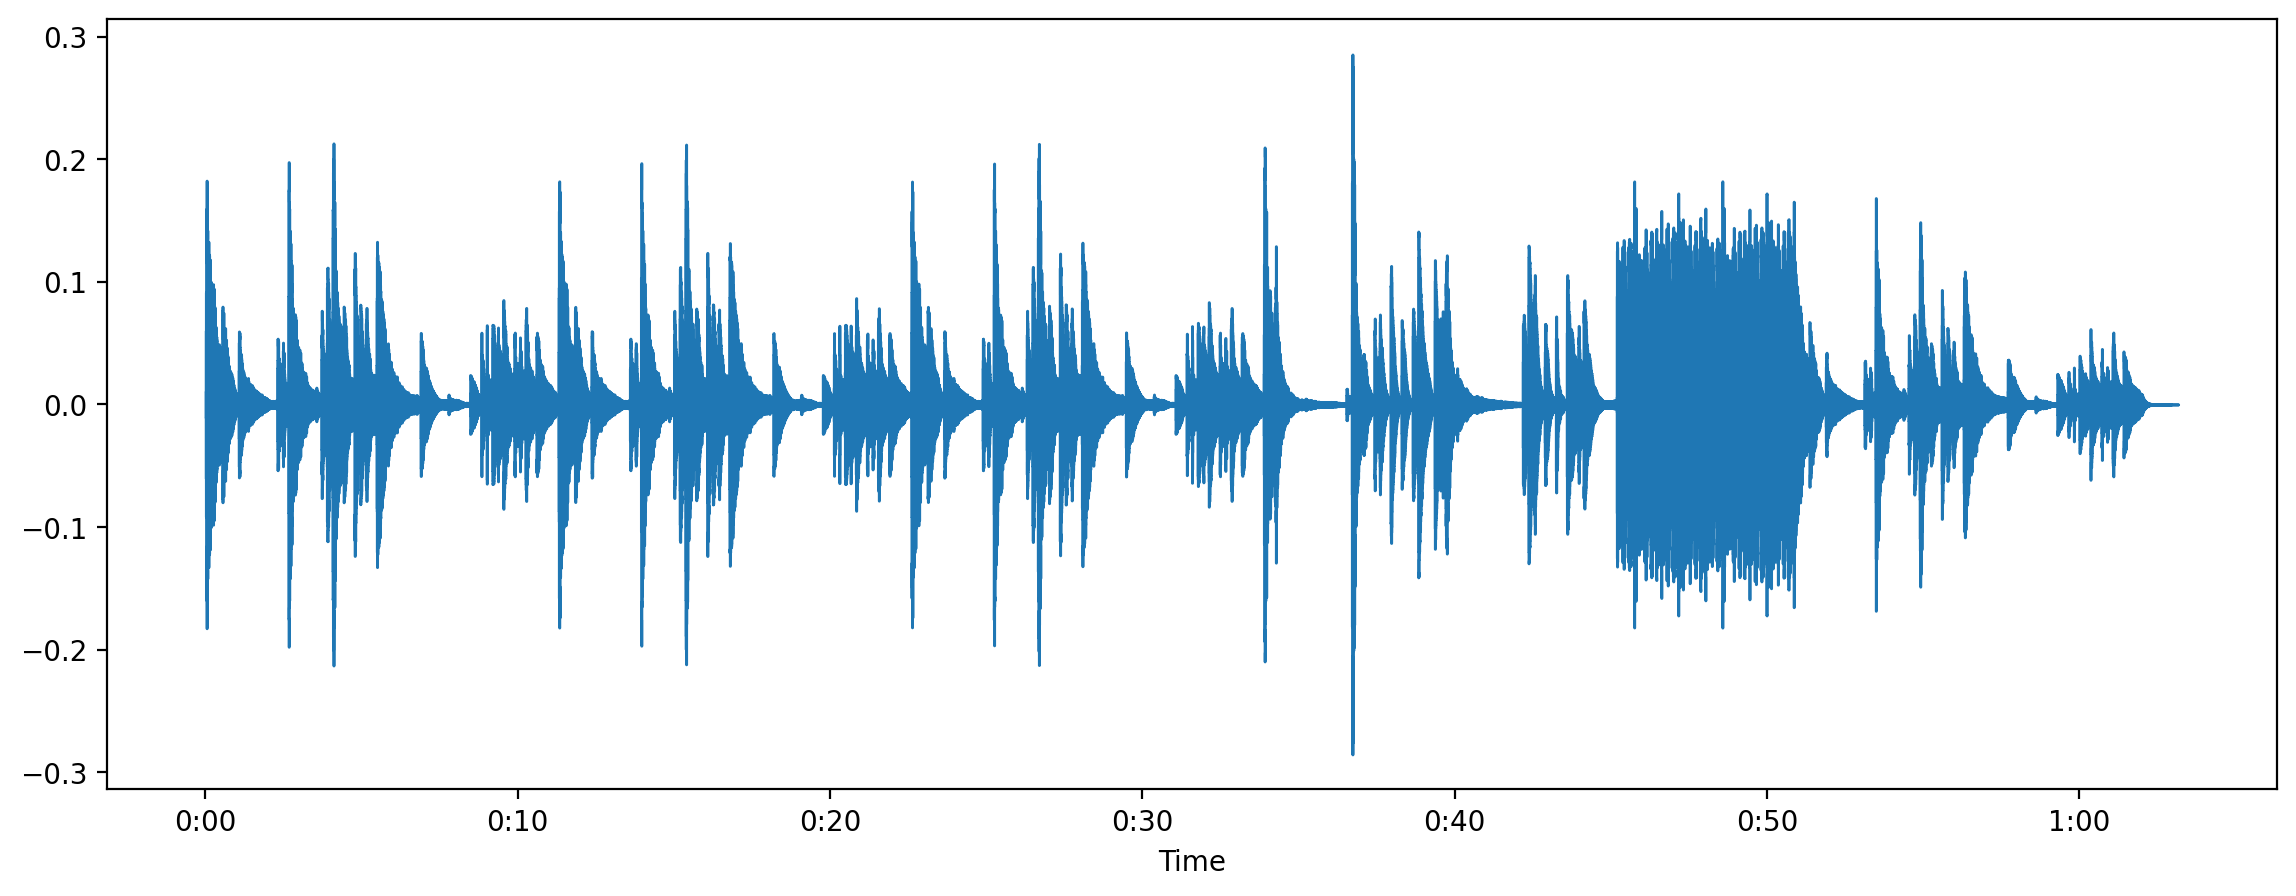

In [79]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x,sr)

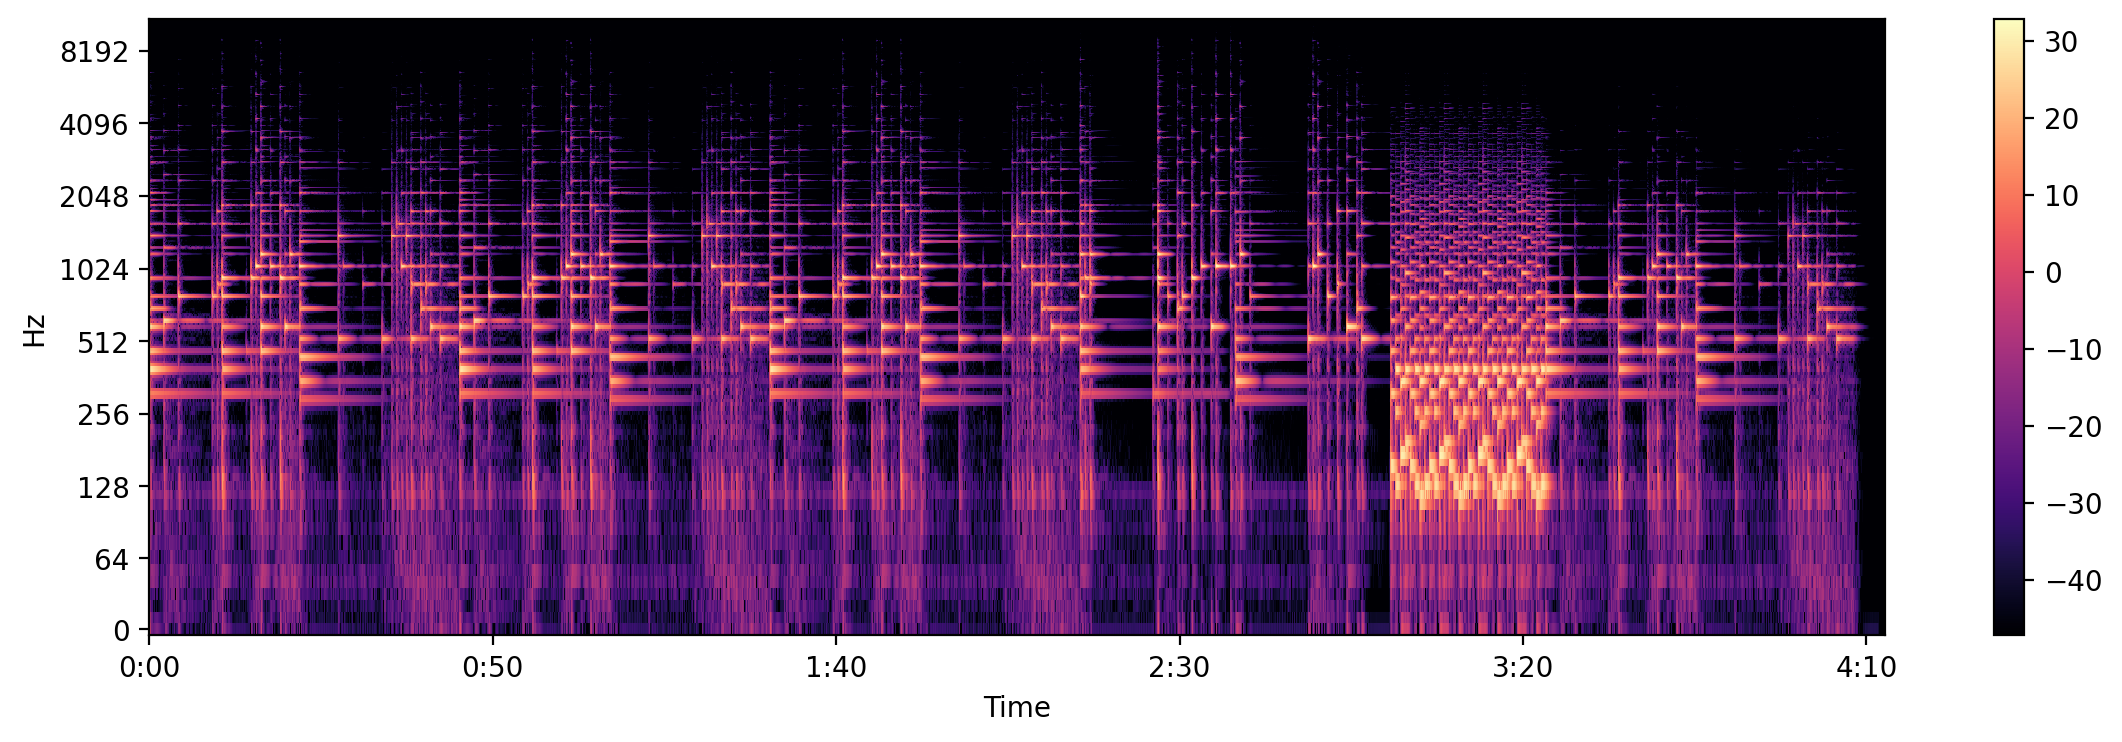

In [80]:
S = librosa.stft(x, hop_length=128)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [81]:
X, X_phase = librosa.magphase(S)
onsets = librosa.onset.onset_detect(y=x, sr=sr, units='time')
n_components = int(len(onsets)/2)
#T = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=n_components)
W, H = librosa.decompose.decompose(X,n_components=n_components, sort=True)

In [82]:
print(S.shape)
print(x.shape)
H[1].shape
print(H.shape)
print(W.shape)


(1025, 10884)
(1393111,)
(80, 10884)
(1025, 80)


W contains information about the frequencies\
H contains information about temporal properties.

In [83]:
#plt.figure(figsize=(20, 10))
#for n in range(n_components):
    #plt.subplot(5, 5, n+1)
    #plt.plot(W[:,n])
    #plt.ylim(-1, W.max())
    #plt.xlim(0, W.shape[0])
    #plt.ylabel('Component %d' % n)
    #print(np.argmax(W[:,n]) * 11025/1025)

In [84]:
#plt.figure(figsize=(20, 10))
#for n in range(n_components):
    #plt.subplot(5, 5, n+1)
    #plt.plot(H[n])
    #plt.ylim(0, H.max())
    #plt.xlim(0, H.shape[1])
    #plt.ylabel('Component %d' % n)

In [85]:
hop_length = 512
tempo, beats=librosa.beat.beat_track(y=None, sr=sr, onset_envelope=onsets, hop_length=hop_length,
               start_bpm=120.0, tightness=100, trim=True, bpm=None,
               units='frames')
tempo=int(2*round(tempo/2))
mm = MetronomeMark(referent='quarter', number=tempo)
print(mm)
duration = mm.duration
duration = round(1/(tempo * 0.01666667),2)
print(duration)

<music21.tempo.MetronomeMark Quarter=124>
0.48


In [90]:
note_info = []
tuple_list = []
for n in range(n_components):
    spectral = W[:,n]
    temporal = H[n]
    onsets_ = librosa.util.peak_pick(temporal,pre_max = 6, post_max=6,pre_avg=50, post_avg=50,delta=temporal.max()/2,wait=0)
    #print(librosa.hz_to_midi(np.argmax(spectral) * 11025/1025))  #can detect half the sampling frequency
    n = librosa.hz_to_midi(np.argmax(spectral) * (sr/2)/S.shape[0])
    for o in onsets_:
        tuple_list += [[round(o*10/S.shape[1],3),round(n)]]
    print(librosa.hz_to_note(np.argmax(spectral) * 11025/S.shape[0]))  #can detect half the sampling frequency
    print(onsets_ * 10/S.shape[1])



sorted_list = sorted(tuple_list)
big_dictionary = ""
durations = []
for i in range(len(sorted_list)):
    sorted_list[i] += [round(duration,3)]
print(sorted_list[0:len(sorted_list)])


A♯2
[7.3355384  7.55880191 7.78206542 8.0062477 ]
A♯2
[7.32175671 7.54593899 7.76828372 7.99246601]
A♯2
[7.35207644 7.57533995 7.79860345 8.02186696]
C3
[7.19128997 7.35942668 7.53123852 7.58269019 7.80687247 7.97776553
 8.03013598]
C♯3
[7.29051819 7.3768835  7.40260933 7.51470048 7.57074605 7.60106578
 7.62587284 7.73796398 7.82432929 7.84913635 7.96122749 8.01727306]
D3
[7.15913267 7.27030503 7.38239618 7.49356854 7.60565968 7.71683205
 7.82892319 7.94009555]
D3
[7.15361999 7.26479236 7.37780228 7.48805586 7.60106578 7.71223815
 7.82432929 7.93550165]
D3
[7.20874678 7.43201029 7.65619258 7.87945608]
E3
[7.15361999 7.21058434 7.26571114 7.37780228 7.43476663 7.48897464
 7.60106578 7.65803014 7.71223815 7.82432929 7.88129364 7.93642043]
F3
[7.2170158  7.44027931 7.66354282 7.88680632]
F♯3
[7.24182286 7.2491731  7.46600515 7.47335538 7.48713708 7.68926865
 7.69661889 7.91253216 7.9198824  7.93458287]
G3
[7.23631018 7.45957369 7.68283719 7.90701948]
C4
[7.18118339 7.29327453 7.34840132 7

In the library librosa, hop_length is a parameter that determines the number of samples between consecutive frames of a spectrogram. A spectrogram is a visual representation of the spectrum of frequencies in a signal as it varies over time. It is commonly used in audio signal processing to analyze the frequency content of a signal.

In librosa, the hop_length parameter controls the resolution of the spectrogram in the time domain. A smaller hop_length value results in a higher resolution spectrogram with more time points, while a larger hop_length value results in a lower resolution spectrogram with fewer time points.

The hop_length parameter is used in the librosa.stft function, which calculates the short-time Fourier transform of an audio signal. The hop_length determines the overlap between consecutive frames of the spectrogram, with a smaller hop_length resulting in more overlap and a larger hop_length resulting in less overlap.

In summary, hop_length is a parameter in librosa that determines the resolution of a spectrogram in the time domain, and controls the overlap between consecutive frames of the spectrogram. The specific value of hop_length to use will depend on the characteristics of the audio signal and the desired outcome.

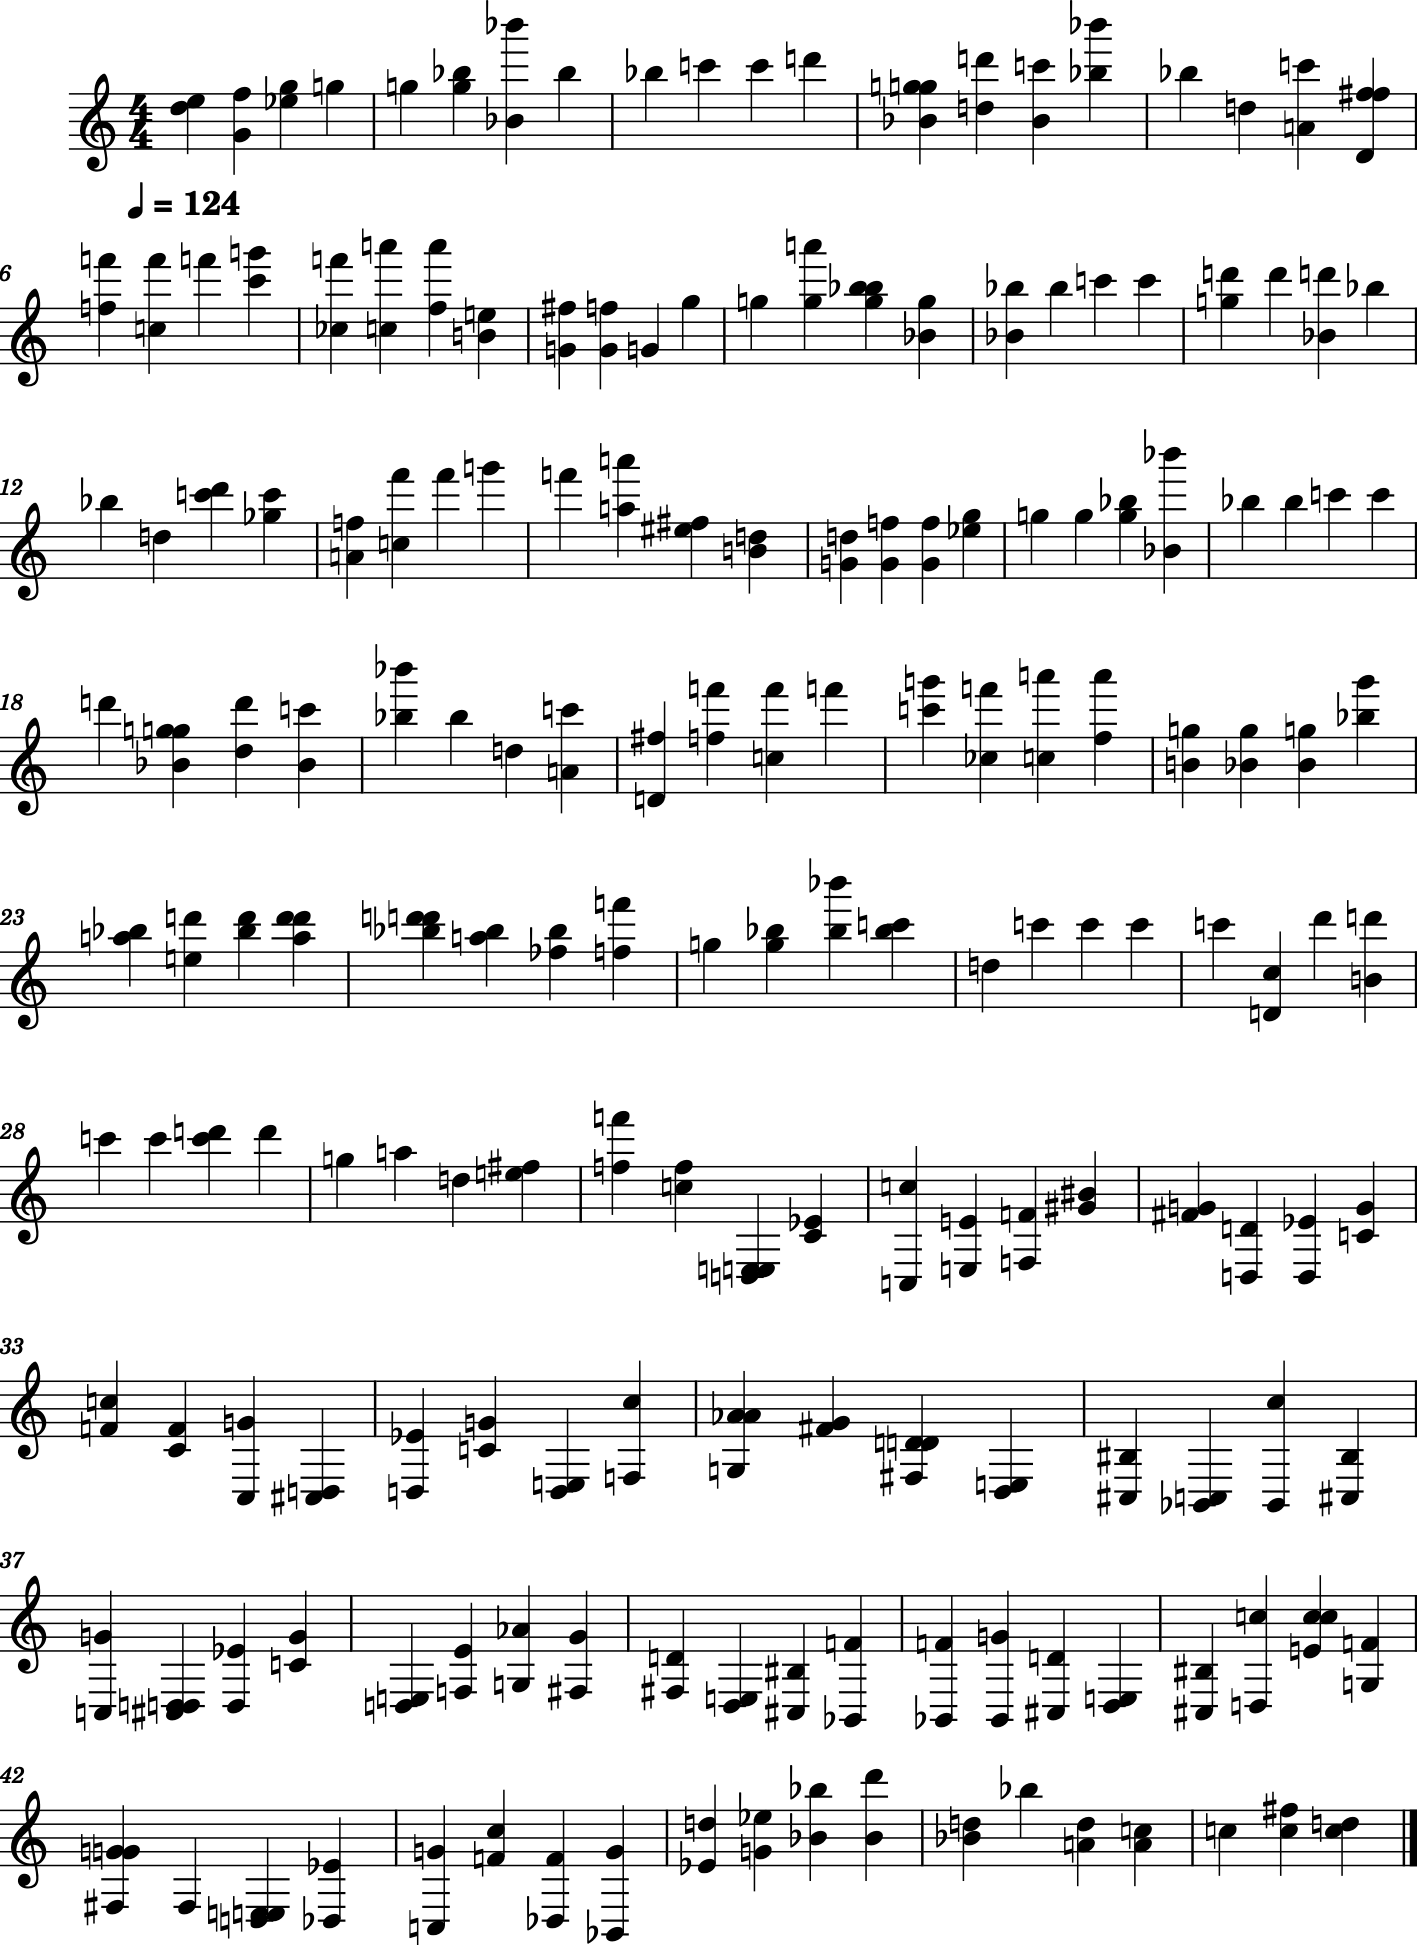

'./nmf_output.mid'

In [89]:
s = stream.Stream()
s.append(mm)
for i in range(0,len(sorted_list)-3,3):
    _onset1 = sorted_list[i][0]
    _onset2 = sorted_list[i+1][0]
    _onset3 = sorted_list[i+1][0]
    _note1 = sorted_list[i][1]
    _note2 = sorted_list[i+1][1]
    _note3 = sorted_list[i+1][1]
    _duration = sorted_list[i][2]
    #if math.isclose(_onset1,_onset2,abs_tol=0.01) and math.isclose(_onset1,_onset3,abs_tol=0.01) and math.isclose(_onset2,_onset3,abs_tol=0.01):
        #c = chord.Chord([_note1 , _note2, _note3])
        #s.append(c)
    if _onset1 == _onset2 == _onset3:
        c = chord.Chord([_note1 , _note2, _note3])
        s.append(c)
    elif _note1 == _note2 == _note3:
        n0 = note.Note(_note1)
        s.append(n0)
    elif _note1==_note2:
        c = chord.Chord([_note1 , _note3])
        s.append(c)
    elif _note1==_note3:
        c = chord.Chord([_note2 , _note3])
        s.append(c)
    elif _note2==_note3:
        c = chord.Chord([_note1 , _note2])
        s.append(c)
    else:
        n0 = note.Note(_note1)
        n1 = note.Note(_note2)
        n2 = note.Note(_note3)
        s.append(n0)
        s.append(n1)
        s.append(n2)
    
s.show()
s.write('midi',fp="./nmf_output.mid")

In [88]:
s = stream.Stream()
s.append(meter.TimeSignature('2/4'))
s.append(note.Rest(quarterLength=0.5))
s.append(note.Note('g', quarterLength=0.5))
s.append(note.Note('e'))
s.append(dMaj)
s.append(note.Note('g', quarterLength=0.5))
s.append(note.Note('g', quarterLength=0.5))
s.append(note.Note('e-', quarterLength=2))

#s.show()
